# ML Project: Deep Learning for Brain Tumor Segmentation on MRI
The goal is to classify brain tumors into the following subregions: enhancing tumor (ET), tumor core (TC), and whole tumor (WT). This involves preprocessing 3D volumetric brain MRI scans and then passing it through a U-Net CNN.

## Downloading Data
Download/cache data with `kagglehub`.

In [2]:
import kagglehub
import os

base_path = kagglehub.dataset_download("awsaf49/brats2020-training-data")
print("Path to dataset files:", base_path)

data_path = os.path.join(base_path, "BraTS2020_training_data", "content", "data")

Using Colab cache for faster access to the 'brats2020-training-data' dataset.
Path to dataset files: /kaggle/input/brats2020-training-data


## Splitting Data
Split training/validation/testing data by volume to prevent data leakage since the slices would be highly correlated.

In [3]:
from collections import defaultdict
import numpy as np

def create_index(data_path):
    index = defaultdict(list)
    for file in os.listdir(data_path):
        if file.endswith(".h5"):
            volume = int(file.split("_")[1])
            file_path = os.path.join(data_path, file)
            index[volume].append(file_path)
    return dict(index)

index = create_index(data_path)

def split_data(index, test_frac=0.1, val_frac=0.1, seed=42):
    volumes = sorted(index.keys())
    rng = np.random.default_rng(seed)
    rng.shuffle(volumes)

    size = len(volumes)
    test_size = int(size * test_frac)
    val_size = int(size * val_frac)

    test_volumes = volumes[:test_size]
    val_volumes = volumes[test_size:test_size + val_size]
    train_volumes = volumes[test_size + val_size:]

    def get_paths(volumes):
        paths = []
        for vol in volumes:
            paths.extend(index[vol])
        return paths

    train_paths = get_paths(train_volumes)
    val_paths = get_paths(val_volumes)
    test_paths = get_paths(test_volumes)

    return train_paths, val_paths, test_paths

train_paths, val_paths, test_paths = split_data(index, test_frac=0.3, val_frac=0.2, seed=42)
print("Training data:", len(train_paths))
print("Validation data:", len(val_paths))
print("Testing data:", len(test_paths))

Training data: 28830
Validation data: 11315
Testing data: 17050


## Preprocessing
Use a Keras Sequence for a better data pipeline. Note that the model predicts the following: necrotic and non-enhancing tumor core (NCR/NET), peritumoral edema (ED), and GD-enhancing tumor (ET). These will be used to derive ET, TC, and WT.

In [4]:
import tensorflow as tf
print("GPUs:", tf.config.list_physical_devices("GPU"))

from tensorflow import keras
from keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")
import h5py

class DataGenerator(keras.utils.Sequence):
    def __init__(self, paths, batch_size=8, shuffle=True, seed=42, **kwargs):
        super().__init__(**kwargs)
        self.paths = list(paths)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.rng = np.random.default_rng(seed)
        self.on_epoch_end()

    def __getitem__(self, idx):
        batch_paths = self.paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        xs, ys = [], []
        for h5_path in batch_paths:
            with h5py.File(h5_path, "r") as file:
                image = file["image"][()]
                mask = file["mask"][()]

            x = image.astype(np.float32)
            ncr = mask[:, :, 0]
            ed = mask[:, :, 1]
            et = mask[:, :, 2]
            y = np.zeros(ncr.shape, dtype=np.uint8)
            y[ncr == 1] = 1
            y[ed == 1]  = 2
            y[et == 1]  = 3

            xs.append(x)
            ys.append(y)
        return np.array(xs), np.array(ys)

    def __len__(self):
        return int(np.ceil(len(self.paths) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            self.rng.shuffle(self.paths)

train_generator = DataGenerator(train_paths, batch_size=8, shuffle=True, seed=42, workers=8, use_multiprocessing=True)
val_generator = DataGenerator(val_paths, batch_size=8, shuffle=False, workers=8, use_multiprocessing=True)
test_generator = DataGenerator(test_paths, batch_size=8, shuffle=False, workers=8, use_multiprocessing=True)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## CNN
Build a U-Net CNN model to feed the data generators into.

In [5]:
layers = keras.layers
models = keras.models

def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def unet_2d_model(filters=32):
    inputs = layers.Input((240, 240, 4))

    skip1 = conv_block(inputs, filters)
    encoder1 = layers.MaxPool2D(2)(skip1)

    skip2 = conv_block(encoder1, filters * 2)
    encoder2 = layers.MaxPool2D(2)(skip2)

    skip3 = conv_block(encoder2, filters * 4)
    encoder3 = layers.MaxPool2D(2)(skip3)

    skip4 = conv_block(encoder3, filters * 8)
    encoder4 = layers.MaxPool2D(2)(skip4)

    bridge = conv_block(encoder4, filters * 16)

    upsample1 = layers.UpSampling2D(2)(bridge)
    connect1 = layers.Concatenate()([upsample1, skip4])
    decoder1 = conv_block(connect1, filters * 8)

    upsample2 = layers.UpSampling2D(2)(decoder1)
    connect2 = layers.Concatenate()([upsample2, skip3])
    decoder2 = conv_block(connect2, filters * 4)

    upsample3 = layers.UpSampling2D(2)(decoder2)
    connect3 = layers.Concatenate()([upsample3, skip2])
    decoder3 = conv_block(connect3, filters * 2)

    upsample4 = layers.UpSampling2D(2)(decoder3)
    connect4 = layers.Concatenate()([upsample4, skip1])
    decoder4 = conv_block(connect4, filters)

    outputs = layers.Conv2D(4, 1, padding="same", activation="softmax")(decoder4)

    model = models.Model(inputs, outputs)
    return model

model = unet_2d_model(filters=32)
model.compile(optimizer=keras.optimizers.Adam(1e-4), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=["sparse_categorical_accuracy"], jit_compile=True)
history = model.fit(train_generator, validation_data=val_generator, epochs=12, steps_per_epoch=300, validation_steps=300)

Epoch 1/12
300/300 ━━━━━━━━━━━━━━━━━━━━ 121s 208ms/step - loss: 0.7964 - sparse_categorical_accuracy: 0.8294 - val_loss: 0.4430 - val_sparse_categorical_accuracy: 0.9893
Epoch 2/12
300/300 ━━━━━━━━━━━━━━━━━━━━ 59s 196ms/step - loss: 0.2814 - sparse_categorical_accuracy: 0.9915 - val_loss: 0.2079 - val_sparse_categorical_accuracy: 0.9922
Epoch 3/12
300/300 ━━━━━━━━━━━━━━━━━━━━ 62s 204ms/step - loss: 0.1789 - sparse_categorical_accuracy: 0.9922 - val_loss: 0.1293 - val_sparse_categorical_accuracy: 0.9929
Epoch 4/12
300/300 ━━━━━━━━━━━━━━━━━━━━ 98s 326ms/step - loss: 0.1166 - sparse_categorical_accuracy: 0.9937 - val_loss: 0.0914 - val_sparse_categorical_accuracy: 0.9923
Epoch 5/12
300/300 ━━━━━━━━━━━━━━━━━━━━ 61s 202ms/step - loss: 0.0810 - sparse_categorical_accuracy: 0.9944 - val_loss: 0.0640 - val_sparse_categorical_accuracy: 0.9941
Epoch 6/12
300/300 ━━━━━━━━━━━━━━━━━━━━ 61s 203ms/step - loss: 0.0591 - sparse_categorical_accuracy: 0.9946 - val_loss: 0.0494 - val_sparse_categorical_ac

## Results
Show training and validation graphs and evaluate the model on test data.

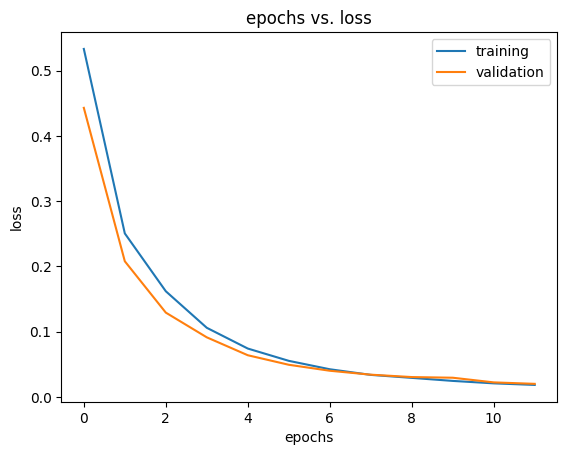

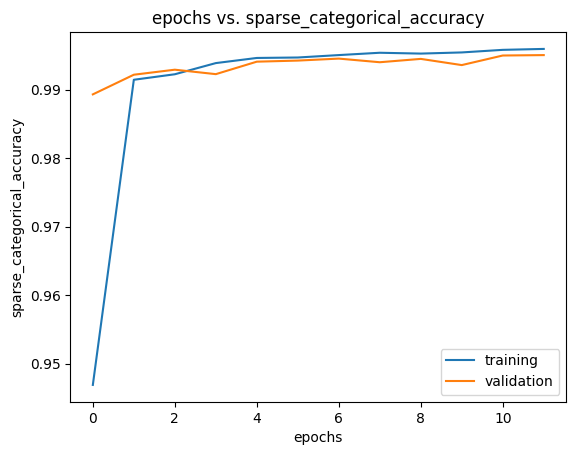

2132/2132 ━━━━━━━━━━━━━━━━━━━━ 226s 105ms/step - loss: 0.0181 - sparse_categorical_accuracy: 0.9958
Test loss: 0.019392909482121468
Test accuracy: 0.9954381585121155


In [6]:
import matplotlib.pyplot as plt

def plot_graph(history, metric):
    plt.figure()
    plt.title(f"epochs vs. {metric}")
    plt.xlabel("epochs")
    plt.ylabel(metric)
    plt.plot(history.history[metric])
    plt.plot(history.history[f"val_{metric}"])
    plt.legend(["training", "validation"])
    plt.show()

plot_graph(history, "loss")
plot_graph(history, "sparse_categorical_accuracy")

test_results = model.evaluate(test_generator)
print("Test loss:", test_results[0])
print("Test accuracy:", test_results[1])

## Example Prediction
Display an example segmentation prediction for a particular random image.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


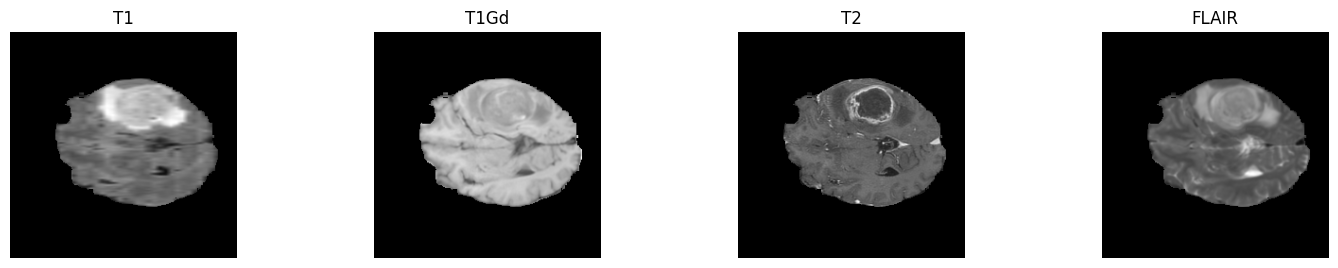

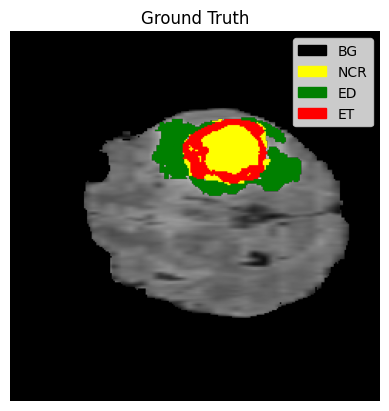

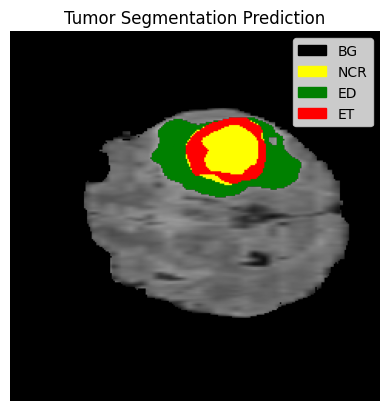

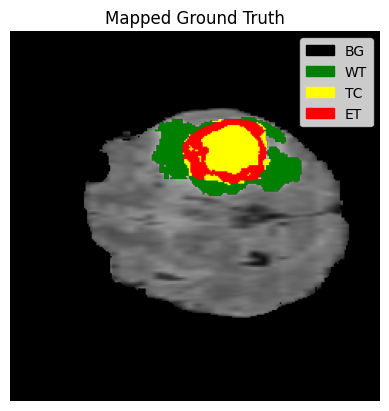

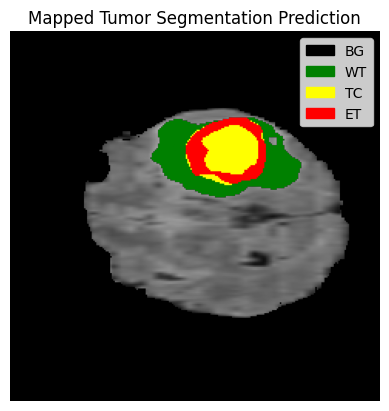

In [52]:
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap

def get_random_xy(test_generator, min_tumor_pixels=500):
    random_x, random_y = None, None
    while True:
        x_batch, y_batch = test_generator[np.random.randint(len(test_generator))]
        random_idx = np.random.randint(len(x_batch))
        random_x = x_batch[random_idx]
        random_y = y_batch[random_idx]
        if np.count_nonzero(random_y != 0) > min_tumor_pixels:
            break
    return random_x, random_y

random_x, random_y = get_random_xy(test_generator, min_tumor_pixels=500)

def predict(x):
    raw_pred = model.predict(np.expand_dims(x, axis=0))
    pred = np.argmax(raw_pred[0], axis=-1)
    return pred

prediction = predict(random_x)

def plot_x(x):
    titles = ["T1", "T1Gd", "T2", "FLAIR"]
    plt.figure(figsize=(18, 10))
    for scan in range(4):
        plt.subplot(3, 4, scan+1)
        plt.imshow(x[:, :, scan], cmap="gray")
        plt.title(titles[scan])
        plt.axis("off")
    plt.show()

plot_x(random_x)

def plot_y(x, y, title):
    plt.figure()
    plt.imshow(x[:, :, 0], cmap="gray")
    y_masked = np.ma.masked_where(y == 0, y)
    cmap = ListedColormap(["black", "yellow", "green", "red"])
    plt.imshow(y_masked, cmap=cmap, vmin=0, vmax=3)
    plt.title(title)
    plt.axis("off")
    legend = [
        patches.Patch(color="black", label="BG"),
        patches.Patch(color="yellow", label="NCR"),
        patches.Patch(color="green", label="ED"),
        patches.Patch(color="red", label="ET"),
    ]
    plt.legend(handles=legend, loc="best")
    plt.show()

plot_y(random_x, random_y, "Ground Truth")
plot_y(random_x, prediction, "Tumor Segmentation Prediction")

def map_subregions(y):
    wt = (y != 0)
    tc = (y == 1) | (y == 3)
    et = (y == 3)
    mapped_y = np.zeros(y.shape)
    mapped_y[wt] = 1
    mapped_y[tc] = 2
    mapped_y[et] = 3
    return mapped_y

mapped_y = map_subregions(random_y)
mapped_prediction = map_subregions(prediction)

def plot_mapped_y(x, y, title):
    plt.figure()
    plt.imshow(x[:, :, 0], cmap="gray")
    y_masked = np.ma.masked_where(y == 0, y)
    cmap = ListedColormap(["black", "green", "yellow", "red"])
    plt.imshow(y_masked, cmap=cmap, vmin=0, vmax=3)
    plt.title(title)
    plt.axis("off")
    legend = [
        patches.Patch(color="black", label="BG"),
        patches.Patch(color="green", label="WT"),
        patches.Patch(color="yellow", label="TC"),
        patches.Patch(color="red", label="ET"),
    ]
    plt.legend(handles=legend, loc="best")
    plt.show()

plot_mapped_y(random_x, mapped_y, "Mapped Ground Truth")
plot_mapped_y(random_x, mapped_prediction, "Mapped Tumor Segmentation Prediction")
